In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# load the dataset
training_df = pd.read_excel('linear_selected_features.xlsx')

training_df.head()

,1891,1894,1898,1902,1905,1907,1910,1968,1971,1979,1982,1985,1988,Water Potential (Mpa)
0,0.0814,0.0678,0.0574,0.0311,0.0284,0.0269,0.0259,0.0336,0.0347,0.0395,0.0410,0.0430,0.0448,-0.089632
1,0.0983,0.0855,0.0757,0.0515,0.0490,0.0464,0.0446,0.0522,0.0534,0.0580,0.0598,0.0615,0.0631,-0.148237
2,0.0633,0.0533,0.0459,0.0282,0.0251,0.0238,0.0230,0.0280,0.0290,0.0321,0.0333,0.0347,0.0359,-0.128243
3,0.0969,0.0831,0.0734,0.0493,0.0456,0.0433,0.0421,0.0475,0.0487,0.0531,0.0550,0.0564,0.0579,-0.164785
4,0.0784,0.0662,0.0573,0.0336,0.0317,0.0301,0.0286,0.0343,0.0354,0.0391,0.0406,0.0421,0.0438,-0.326122


In [3]:
# ---------------------------------
# Define predictors and target
# ---------------------------------
X = training_df.drop(columns = ['Water Potential (Mpa)'])
y = training_df['Water Potential (Mpa)']

In [4]:
# Feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# <font color = Orange> Multiple Linear Regression - PLSR

In [5]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for n_components to be integers between 1 and the number of features
    n_components = trial.suggest_int('n_components', 1, X_train.shape[1])
    # Set the range for max_iter to be between 100 and 1000
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the PLSR model with the specified hyperparameters
    model = PLSRegression(n_components=n_components, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_plsr = PLSRegression(n_components=trial.params['n_components'], max_iter=trial.params['max_iter'])

# Fit the model
best_plsr.fit(X_train, y_train)

# Make predictions
y_pred = best_plsr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:08:01,385] A new study created in memory with name: no-name-277fe436-56a4-4b74-9882-862ede788e1c
[I 2024-03-07 15:08:01,411] Trial 0 finished with value: 2.8286270757829772 and parameters: {'n_components': 13, 'max_iter': 518}. Best is trial 0 with value: 2.8286270757829772.
[I 2024-03-07 15:08:01,424] Trial 1 finished with value: 3.506171125531679 and parameters: {'n_components': 3, 'max_iter': 624}. Best is trial 0 with value: 2.8286270757829772.
[I 2024-03-07 15:08:01,438] Trial 2 finished with value: 2.7102615923427393 and parameters: {'n_components': 9, 'max_iter': 716}. Best is trial 2 with value: 2.7102615923427393.
[I 2024-03-07 15:08:01,451] Trial 3 finished with value: 3.057093237794413 and parameters: {'n_components': 2, 'max_iter': 771}. Best is trial 2 with value: 2.7102615923427393.
[I 2024-03-07 15:08:01,467] Trial 4 finished with value: 2.904386804152622 and parameters: {'n_components': 4, 'max_iter': 778}. Best is trial 2 with value: 2.7102615923427393

[I 2024-03-07 15:08:02,841] Trial 46 finished with value: 3.057093237794413 and parameters: {'n_components': 2, 'max_iter': 107}. Best is trial 18 with value: 2.412852944578769.
[I 2024-03-07 15:08:02,873] Trial 47 finished with value: 2.904386804152622 and parameters: {'n_components': 4, 'max_iter': 391}. Best is trial 18 with value: 2.412852944578769.
[I 2024-03-07 15:08:02,909] Trial 48 finished with value: 2.412852944578769 and parameters: {'n_components': 1, 'max_iter': 732}. Best is trial 18 with value: 2.412852944578769.
[I 2024-03-07 15:08:02,944] Trial 49 finished with value: 3.3575383083725097 and parameters: {'n_components': 5, 'max_iter': 149}. Best is trial 18 with value: 2.412852944578769.
[I 2024-03-07 15:08:02,975] Trial 50 finished with value: 3.057093237794413 and parameters: {'n_components': 2, 'max_iter': 297}. Best is trial 18 with value: 2.412852944578769.
[I 2024-03-07 15:08:03,004] Trial 51 finished with value: 2.412852944578769 and parameters: {'n_components': 

[I 2024-03-07 15:08:04,484] Trial 92 finished with value: 2.412852944578769 and parameters: {'n_components': 1, 'max_iter': 336}. Best is trial 18 with value: 2.412852944578769.
[I 2024-03-07 15:08:04,510] Trial 93 finished with value: 2.412852944578769 and parameters: {'n_components': 1, 'max_iter': 270}. Best is trial 18 with value: 2.412852944578769.
[I 2024-03-07 15:08:04,538] Trial 94 finished with value: 3.057093237794413 and parameters: {'n_components': 2, 'max_iter': 991}. Best is trial 18 with value: 2.412852944578769.
[I 2024-03-07 15:08:04,567] Trial 95 finished with value: 2.412852944578769 and parameters: {'n_components': 1, 'max_iter': 415}. Best is trial 18 with value: 2.412852944578769.
[I 2024-03-07 15:08:04,595] Trial 96 finished with value: 2.412852944578769 and parameters: {'n_components': 1, 'max_iter': 251}. Best is trial 18 with value: 2.412852944578769.
[I 2024-03-07 15:08:04,622] Trial 97 finished with value: 3.057093237794413 and parameters: {'n_components': 2

Number of finished trials:  100
Best trial:
  Value: 2.412852944578769
  Params: 
    n_components: 1
    max_iter: 710
Mean Squared Error: 2.412852944578769
Root Mean Squared Error: 1.5533360694256633
R-Squared value: 0.40061810929050967


In [6]:
# Get the coefficients from the trained PLSRegression model
coefficients = best_plsr.coef_.flatten()

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")

Top 3 Features:
1898: -0.05774543336307089
1894: -0.05756724668151457
1902: -0.05728587189981572


# <font color = Blue> Elastic Net

In [7]:
# Tune the hyperparameters using Optuna
def objective(trial):
    
    # Set the range for alpha to be uniform between 0.0 and 1.0, alpha is the regularization parameter
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for l1_ratio to be uniform between 0.0 and 1.0, l1_ratio is the ElasticNet mixing parameter
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    # Set the range for max_iter to be between 100 and 1000, max_iter is the maximum number of iterations
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    # Create the ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    # Return mse as the objective value
    return mse

# Create the Optuna study, we maximize the objective function (the score)
# model.score() returns the coefficient of determination R^2 of the prediction 
# i.e. the percentage of the variance in the target variable that is predictable from the feature variables
study = optuna.create_study(direction='minimize', sampler = TPESampler(seed=37))
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial

# Print the value of the final trial and the best parameters
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_elastic_net = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio'], max_iter=study.best_params['max_iter'])

# Fit the model
best_elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = best_elastic_net.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:08:04,757] A new study created in memory with name: no-name-4106bb60-593f-4241-8218-6d5603434bbf
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:08:04,779] Trial 0 finished with value: 4.64312002885122 and parameters: {'alpha': 0.9444966028573069, 'l1_ratio': 0.4640981743044076, 'max_iter': 273}. Best is trial 0 with value: 4.64312002885122.
/var/folders/3h/631y9grn

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:08:04,968] Trial 10 finished with value: 2.5501693482414436 and parameters: {'alpha': 0.27682391622961355, 'l1_ratio': 0.06343733200190918, 'max_iter': 457}. Best is trial 7 with value: 2.506359404645653.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated

[I 2024-03-07 15:08:05,259] Trial 18 finished with value: 2.5438092130532985 and parameters: {'alpha': 0.1576797983469223, 'l1_ratio': 0.16390791650330228, 'max_iter': 303}. Best is trial 7 with value: 2.506359404645653.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:08:05,287] Trial 19 finished with value: 2.7547407623362177 and parameters: {'alpha': 0.22134439427291244, 'l1_ratio

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:08:05,563] Trial 29 finished with value: 4.80810465713397 and parameters: {'alpha': 0.9668894200089733, 'l1_ratio': 0.4805734544344706, 'max_iter': 224}. Best is trial 26 with value: 2.45570109785973.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:08:05,919] Trial 39 finished with value: 2.5152324728760367 and parameters: {'alpha': 0.12829464692233017, 'l1_ratio': 0.1581141370206375, 'max_iter': 385}. Best is trial 26 with value: 2.45570109785973.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:08:06,273] Trial 49 finished with value: 2.4604182388980185 and parameters: {'alpha': 0.03418291686241523, 'l1_ratio': 0.6963961298303268, 'max_iter': 516}. Best is trial 48 with value: 2.4358994296670566.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

[I 2024-03-07 15:08:06,655] Trial 58 finished with value: 3.2461000681831282 and parameters: {'alpha': 0.2479377292440625, 'l1_ratio': 0.8822921039946219, 'max_iter': 632}. Best is trial 48 with value: 2.4358994296670566.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:08:06,691] Trial 59 finished with value: 2.733130671850251 and parameters: {'alpha': 0.16051050980957776, 'l1_ratio

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:08:07,025] Trial 68 finished with value: 2.8179549659882155 and parameters: {'alpha': 0.482773516944859, 'l1_ratio': 0.1817238798817971, 'max_iter': 559}. Best is trial 48 with value: 2.4358994296670566.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated 

[I 2024-03-07 15:08:07,436] Trial 77 finished with value: 2.5692319086355 and parameters: {'alpha': 0.06747166771490848, 'l1_ratio': 0.8521417645644127, 'max_iter': 352}. Best is trial 48 with value: 2.4358994296670566.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:08:07,464] Trial 78 finished with value: 2.9163342948103264 and parameters: {'alpha': 0.1779268831048486, 'l1_ratio':

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:08:07,814] Trial 87 finished with value: 2.447651747599885 and parameters: {'alpha': 0.020491671197333, 'l1_ratio': 0.562476794648555, 'max_iter': 476}. Best is trial 82 with value: 2.4306596305137163.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in

[I 2024-03-07 15:08:08,175] Trial 96 finished with value: 2.4310476540016492 and parameters: {'alpha': 0.027487512415186453, 'l1_ratio': 0.46710099959561746, 'max_iter': 333}. Best is trial 82 with value: 2.4306596305137163.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:08:08,217] Trial 97 finished with value: 2.4885820740566644 and parameters: {'alpha': 0.057663185153495944, 'l1_

Number of finished trials:  100
Best trial:
  Value: 2.4306596305137163
  Params: 
    alpha: 0.024727052063564455
    l1_ratio: 0.5630409847649548
    max_iter: 449
Mean Squared Error: 2.4306596305137163
Root Mean Squared Error: 1.5590572890415915
R-Squared value: 0.3961947128680551


In [8]:
# Get the coefficients from the trained ElasticNet model
coefficients = best_elastic_net.coef_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")


Top 3 Features:
1898: -0.38022255625961365
1894: -0.24877956067931686
1902: -0.1841754360031094


# <font color = Red> Non-linear Kernel Ridge Regression (KRR)

In [9]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for alpha to be uniform between 0.0 and 1.0
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for gamma to be loguniform between 1e-6 and 1e6
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
    # Set the range for kernel to be categorical between 'linear' and 'rbf'
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    
    # Create the Kernel Ridge Regression model with the specified hyperparameters
    model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

# Fit the model
best_krr.fit(X_train, y_train)

# Make predictions
y_pred = best_krr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:08:08,469] A new study created in memory with name: no-name-0818800b-3946-4ba0-814a-65d4454c15ae
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:08:08,511] Trial 0 finished with value: 7.9580212148730425 and parameters: {'alpha': 0.9444966028573069, 'gamma': 0.3708327584362581, 'kernel': 'rbf'}. Best is trial 0 with value: 7.9580212148730425.
/var/fold

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:08:08,692] Trial 10 finished with value: 3.287743150909328 and parameters: {'alpha': 0.003915949640957761, 'gamma': 8.218006795527931e-06, 'kernel': 'rbf'}. Best is trial 10 with value: 3.287743150909328.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has be

[I 2024-03-07 15:08:08,991] Trial 19 finished with value: 4.292217097174927 and parameters: {'alpha': 0.2533899667693353, 'gamma': 0.07425657734301377, 'kernel': 'rbf'}. Best is trial 12 with value: 2.526697268284965.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:08:09,017] Trial 20 finished with value: 3.1739680663424377 and parameters: {'alpha': 0.09214436620061181

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:08:09,212] Trial 29 finished with value: 8.015457433546372 and parameters: {'alpha': 0.9668894200089733, 'gamma': 0.40089333133208455, 'kernel': 'rbf'}. Best is trial 12 with value: 2.526697268284965.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has bee

[I 2024-03-07 15:08:09,485] Trial 38 finished with value: 6.780684091323454 and parameters: {'alpha': 0.8603166234018824, 'gamma': 0.2754074399704092, 'kernel': 'linear'}. Best is trial 12 with value: 2.526697268284965.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:08:09,545] Trial 39 finished with value: 5.862250642819244 and parameters: {'alpha': 0.2987146998095839

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:08:09,817] Trial 48 finished with value: 9.604881678930271 and parameters: {'alpha': 0.004513591673207501, 'gamma': 34.63691752880578, 'kernel': 'rbf'}. Best is trial 12 with value: 2.526697268284965.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has bee

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:08:10,061] Trial 58 finished with value: 2.7411461014005614 and parameters: {'alpha': 0.18488118896212397, 'gamma': 0.005624919802876106, 'kernel': 'rbf'}. Best is trial 12 with value: 2.526697268284965.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has bee

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:08:10,346] Trial 68 finished with value: 2.6324399514665298 and parameters: {'alpha': 0.07428054335055674, 'gamma': 0.004445995497334669, 'kernel': 'rbf'}. Best is trial 12 with value: 2.526697268284965.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has bee

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:08:10,590] Trial 77 finished with value: 4.570505484422303 and parameters: {'alpha': 0.08102939920316096, 'gamma': 4.136391468473189e-05, 'kernel': 'rbf'}. Best is trial 12 with value: 2.526697268284965.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:08:10,923] Trial 87 finished with value: 8.13592448693683 and parameters: {'alpha': 0.023563384276688915, 'gamma': 0.00030876585768131666, 'kernel': 'linear'}. Best is trial 12 with value: 2.526697268284965.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has

[I 2024-03-07 15:08:11,201] Trial 96 finished with value: 5.0097498432419165 and parameters: {'alpha': 0.0529597939153368, 'gamma': 1.6101707540995035e-05, 'kernel': 'rbf'}. Best is trial 92 with value: 2.5251158289841285.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:08:11,228] Trial 97 finished with value: 2.682028188366266 and parameters: {'alpha': 0.0206399594837

Number of finished trials:  100
Best trial:
  Value: 2.5251158289841285
  Params: 
    alpha: 0.01884593960481527
    gamma: 0.0005311879127539133
    kernel: rbf
Mean Squared Error: 2.5251158289841285
Root Mean Squared Error: 1.589061304350505
R-Squared value: 0.37273064931804445


In [10]:
# Get the dual coefficients from the trained KernelRidge model
coefficients = best_krr.dual_coef_

# Calculate the squared magnitude of coefficients (as they are signed)
squared_magnitude = np.abs(coefficients) ** 2

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, squared_magnitude))

# Sort the features by their squared magnitude (importance)
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, magnitude in sorted_features[:top_n]:
    print(f"{feature}: {magnitude}")


Top 3 Features:
1971: 13283.415254090338
1910: 3432.6500462215427
1898: 2368.080340998752


# Principal Component Regression (PCR)

Number of components that explain at least 95% of the variance: 1


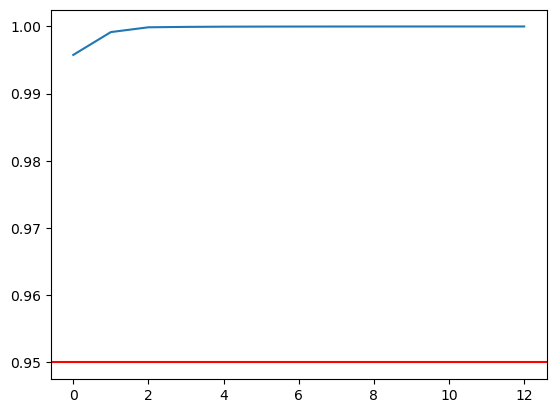

In [11]:
# Create an instance of PCA
pca = PCA(random_state= 37)

# Perform PCA on the predictors DataFrame
pca.fit(X)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance with a vertical line at 95%
plt.plot(cumulative_explained_variance)
plt.axhline(y=0.95, color='r', linestyle='-')

# Find the number of components that explain at least 95% of the variance
pca_n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f'Number of components that explain at least 95% of the variance: {pca_n_components}')

In [12]:
# Define the number of principal components to retain
n_components = pca_n_components

# Create a pipeline with PCA and Linear Regression
pipeline = make_pipeline(PCA(n_components), LinearRegression())

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 2.413746192711413
Root Mean Squared Error: 1.5536235685362827
R-Squared value: 0.400396215637264


In [13]:
# Get the principal components from the trained PCA model within the pipeline
principal_components = pipeline.named_steps['pca'].components_

# Calculate the squared loadings of each feature on the principal components
squared_loadings = principal_components ** 2

# Sum the squared loadings across principal components to get feature importance
feature_importance = squared_loadings.sum(axis=0)

# Get the names of the original features
feature_names = X.columns

# Create a dictionary to store feature importance with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
1910: 0.07911245715712523
1907: 0.07895340853761851
1905: 0.07846301965938765


# <font color = Purple> Ensemble Methods

## <font color = darkgreen> Random Forest Regression

In [14]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the Random Forest model with the specified hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Random Forest model using the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    min_samples_split=trial.params['min_samples_split'], 
    min_samples_leaf=trial.params['min_samples_leaf']
)

# Fit the model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:08:11,739] A new study created in memory with name: no-name-aa280583-e035-4cd9-80ec-b4edd2c59e7c
[I 2024-03-07 15:08:11,988] Trial 0 finished with value: 4.051660435999113 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 4.051660435999113.
[I 2024-03-07 15:08:12,144] Trial 1 finished with value: 4.706875090738202 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 4.051660435999113.
[I 2024-03-07 15:08:12,256] Trial 2 finished with value: 4.493773539933078 and parameters: {'n_estimators': 78, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 4.051660435999113.
[I 2024-03-07 15:08:12,394] Trial 3 finished with value: 3.542337907237904 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 3 with value: 3.542

[I 2024-03-07 15:08:17,928] Trial 36 finished with value: 3.37462940251473 and parameters: {'n_estimators': 138, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 31 with value: 2.332309781810041.
[I 2024-03-07 15:08:18,075] Trial 37 finished with value: 4.420510986437944 and parameters: {'n_estimators': 92, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 31 with value: 2.332309781810041.
[I 2024-03-07 15:08:18,236] Trial 38 finished with value: 3.8358567447186513 and parameters: {'n_estimators': 104, 'max_depth': 21, 'min_samples_split': 19, 'min_samples_leaf': 4}. Best is trial 31 with value: 2.332309781810041.
[I 2024-03-07 15:08:18,368] Trial 39 finished with value: 3.3080143785656415 and parameters: {'n_estimators': 76, 'max_depth': 25, 'min_samples_split': 16, 'min_samples_leaf': 2}. Best is trial 31 with value: 2.332309781810041.
[I 2024-03-07 15:08:18,576] Trial 40 finished with value: 2.633979097317476 and parameter

[I 2024-03-07 15:08:27,279] Trial 72 finished with value: 2.6109666341239834 and parameters: {'n_estimators': 115, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 50 with value: 2.312700281156567.
[I 2024-03-07 15:08:27,489] Trial 73 finished with value: 2.5047882332630347 and parameters: {'n_estimators': 121, 'max_depth': 28, 'min_samples_split': 11, 'min_samples_leaf': 1}. Best is trial 50 with value: 2.312700281156567.
[I 2024-03-07 15:08:27,667] Trial 74 finished with value: 2.4813923322003193 and parameters: {'n_estimators': 107, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 1}. Best is trial 50 with value: 2.312700281156567.
[I 2024-03-07 15:08:27,883] Trial 75 finished with value: 3.3426079022130537 and parameters: {'n_estimators': 101, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 50 with value: 2.312700281156567.
[I 2024-03-07 15:08:27,999] Trial 76 finished with value: 4.173573857013003 and para

Best trial:
  Value: 2.312700281156567
  Params: 
    n_estimators: 109
    max_depth: 19
    min_samples_split: 11
    min_samples_leaf: 1
Mean Squared Error: 2.3737342239798855
Root Mean Squared Error: 1.5406927740402645
R-Squared value: 0.41033567320893083


In [15]:
# Get feature importances from the trained RandomForestRegressor model
feature_importances = best_rf_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
1907: 0.12180146563270187
1902: 0.1062701452587304
1988: 0.10580516000953057


## <font color = darkgreen> Gradient Boosting Regression

In [16]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjust the range for max_depth
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
    
    # Create the Gradient Boosting model with the specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate  # Pass learning_rate to the model
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Gradient Boosting model using the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate']  # Pass learning_rate to the model
)

# Fit the model
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))


[I 2024-03-07 15:08:31,792] A new study created in memory with name: no-name-9aea6b0a-f4d4-463c-86ff-89e28335f94b
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:31,929] Trial 0 finished with value: 2.6631625280126836 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.027351552606144185}. Best is trial 0 with value: 2.6631625280126836.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.sugg

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:33,301] Trial 14 finished with value: 2.936205849407486 and parameters: {'n_estimators': 76, 'max_depth': 5, 'learning_rate': 0.0978144269260402}. Best is trial 11 with value: 1.82461941544903.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:33,393] Trial 15 finis

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:35,051] Trial 28 finished with value: 2.080354027147384 and parameters: {'n_estimators': 143, 'max_depth': 3, 'learning_rate': 0.067996748221718}. Best is trial 22 with value: 1.6925327406683792.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:35,245] Trial 29 fin

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:37,198] Trial 42 finished with value: 1.9276208374876351 and parameters: {'n_estimators': 73, 'max_depth': 3, 'learning_rate': 0.08953808356245468}. Best is trial 22 with value: 1.6925327406683792.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:37,367] Trial 43 f

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:39,171] Trial 56 finished with value: 1.953823373845755 and parameters: {'n_estimators': 130, 'max_depth': 4, 'learning_rate': 0.07526468771655483}. Best is trial 22 with value: 1.6925327406683792.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:39,358] Trial 57 f

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:41,750] Trial 70 finished with value: 1.893808533539543 and parameters: {'n_estimators': 125, 'max_depth': 3, 'learning_rate': 0.0653136697975747}. Best is trial 22 with value: 1.6925327406683792.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:41,984] Trial 71 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:44,277] Trial 84 finished with value: 2.032039615384218 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.07720843260589315}. Best is trial 83 with value: 1.657509266104703.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:44,410] Trial 85 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:46,892] Trial 98 finished with value: 1.9573643474871123 and parameters: {'n_estimators': 112, 'max_depth': 3, 'learning_rate': 0.09276986542986353}. Best is trial 83 with value: 1.657509266104703.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:08:47,020] Trial 99 f

Best trial:
  Value: 1.657509266104703
  Params: 
    n_estimators: 144
    max_depth: 3
    learning_rate: 0.08444284269929732
Mean Squared Error: 1.74295696271121
Root Mean Squared Error: 1.3202109538673015
R-Squared value: 0.5670283835231836


In [17]:
# Get feature importances from the trained GradientBoostingRegressor model
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
1898: 0.16601464228866006
1905: 0.152930161160946
1910: 0.10878968858127454


## <font color = green> XGBoost

In [18]:
### Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    # Create the XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the XGBoost model using the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate'],
    min_child_weight=trial.params['min_child_weight'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:08:47,193] A new study created in memory with name: no-name-5bb19e8c-349d-4a6c-aa40-3c5c221e0046
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:08:53,225] Trial 13 finished with value: 4.912759242420405 and parameters: {'n_estimators': 135, 'max_depth': 6, 'learning_rate': 0.09963959032879514, 'min_child_weight': 10, 'subsample': 0.6803210004260096, 'colsample_bytree': 0.6440888326121632}. Best is trial 8 with value: 2.9640910461387513.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:08:55,557] Trial 26 finished with value: 3.549050125767435 and parameters: {'n_estimators': 73, 'max_depth': 4, 'learning_rate': 0.06268379733692131, 'min_child_weight': 5, 'subsample': 0.7162187799557216, 'colsample_bytree': 0.8981018237955689}. Best is trial 8 with value: 2.9640910461387513.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9gr

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:08:57,882] Trial 39 finished with value: 3.3741163815241144 and parameters: {'n_estimators': 109, 'max_depth': 4, 'learning_rate': 0.07758398119369411, 'min_child_weight': 5, 'subsample': 0.709868307225885, 'colsample_bytree': 0.974461314720747}. Best is trial 8 with value: 2.9640910461387513.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9gr

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:08:59,673] Trial 52 finished with value: 3.3655939226443965 and parameters: {'n_estimators': 109, 'max_depth': 4, 'learning_rate': 0.06926495713658772, 'min_child_weight': 3, 'subsample': 0.700408610511112, 'colsample_bytree': 0.8539265923178602}. Best is trial 8 with value: 2.9640910461387513.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-03-07 15:09:01,489] Trial 65 finished with value: 2.9972680490306227 and parameters: {'n_estimators': 95, 'max_depth': 4, 'learning_rate': 0.09770215323712127, 'min_child_weight': 5, 'subsample': 0.7818602679371991, 'colsample_bytree': 0.8552548032824541}. Best is trial 54 with value: 2.9468441439919704.
/var/folders/3h/

[I 2024-03-07 15:09:02,238] Trial 71 finished with value: 3.110033685636649 and parameters: {'n_estimators': 105, 'max_depth': 5, 'learning_rate': 0.08727702999571377, 'min_child_weight': 4, 'subsample': 0.7678702881928047, 'colsample_bytree': 0.9080281027415208}. Best is trial 54 with value: 2.9468441439919704.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-03-07 15:09:04,437] Trial 84 finished with value: 3.7593077356661397 and parameters: {'n_estimators': 92, 'max_depth': 8, 'learning_rate': 0.09462766104371115, 'min_child_weight': 2, 'subsample': 0.8046237097973491, 'colsample_bytree': 0.9078223940824499}. Best is trial 83 with value: 2.8539850996722813.
/var/folders/3h/

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-03-07 15:09:05,962] Trial 97 finished with value: 2.9787291130182214 and parameters: {'n_estimators': 99, 'max_depth': 3, 'learning_rate': 0.09233631645423403, 'min_child_weight': 3, 'subsample': 0.8068775877691402, 'colsample_bytree': 0.9499552420454243}. Best is trial 83 with value: 2.8539850996722813.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34222/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/fo

Best trial:
  Value: 2.8539850996722813
  Params: 
    n_estimators: 95
    max_depth: 3
    learning_rate: 0.09295250447998868
    min_child_weight: 3
    subsample: 0.8160551163701841
    colsample_bytree: 0.9113375150015447
Mean Squared Error: 2.8539850996722813
Root Mean Squared Error: 1.6893741739686567
R-Squared value: 0.2910355399230834


In [19]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
1979: 0.17353439331054688
1894: 0.16149891912937164
1891: 0.09862421452999115
